In [1]:
%load_ext autoreload

import kwant
import numpy as np
import matplotlib.pyplot as plt 
import kwant.continuum
import scipy.sparse.linalg as sla
import tinyarray as tiny
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 

%matplotlib widget
mpl.rcParams.update({'font.size': 20, 'text.usetex': True,  'font.family': 'serif', 'font.serif': ['Computer Modern']})

sx = tiny.array([[0 , 1] , [1 , 0]])
sy = tiny.array([[0 , -1j] , [1j , 0]])
sz = tiny.array([[1 , 0] , [0 , -1]])


I = tiny.array([[1 , 0] , [0 , 1]])
t_plus = 0.5*(np.kron(sx , I) + 1j*np.kron(sy , I))
t_minus = t_plus.T
phs = np.kron(sy , sy)

/Users/krishnanganesh/anaconda3/lib/python3.8/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [18]:
from dataclasses import dataclass
from RGFtools import T , sorting_modes , h_0
@dataclass
class JosephsonParameters:
    W : int
    L : int
    t: float
    flux : float
    energy: float
    Delta: float
    phase: float
    mu: float
    tol: float
from scipy.linalg import orth

In [27]:
def calculate_transfer_matrices(slice , params ):
    energy = params.energy
    M00 = np.linalg.inv(T(slice+1 , -1, params))@(energy*np.identity(2*params.W)-  h_0(slice , params)) # <- Calculating the Hamiltonian at slice.
    M01 = -np.linalg.inv(T(slice+1 , -1, params))@T(slice , +1 , params)
    M10 = np.identity(2*params.W)
    M11 = np.zeros(shape = (2*params.W , 2*params.W))

    M = np.block([[M00 , M01],[M10 , M11]]) #<- Matrix to diagonalise for propagating modes in lead
    evals , evecs = np.linalg.eig(M)
    
    # Matrix M is not symmetric, so vectors are not necessarily orthonormal.
    # Let us orthogonalise them:
    evecs_orth = orth(evecs)

    pos_prop , neg_prop , pos_evanesce , neg_evanesce , list_of_eigenvalues = sorting_modes(evals , evecs_orth  , tol = 1e-4)
    # First I am going to glue together all modes that evanesce/propagate in the positive x-direction:
    pos_modes = np.hstack((pos_prop , pos_evanesce))
    neg_modes = np.hstack((neg_prop , neg_evanesce))

    # The U(\pm)-matrices consisten of amplitudes on the j = 0 slice. So we take only the first half rows:
    U_pos = pos_modes[0:int(pos_modes.shape[0]/2) , :]
    U_neg = neg_modes[0:int(neg_modes.shape[0]/2) , :]

    # The \Lambda(\pm) matrix comprises of all the corresponding eigenvalues:
    Lambda_pos = np.diag(np.hstack((list_of_eigenvalues[0] ,list_of_eigenvalues[2])))
    Lambda_neg = np.diag(np.hstack((list_of_eigenvalues[1] , list_of_eigenvalues[3])))

    # Construct the F(\pm) transfer matrices:
    F_pos = U_pos @ Lambda_pos @ np.linalg.inv(U_pos)
    F_neg = U_neg @ Lambda_neg @ np.linalg.inv(U_neg)

    # This is for diagnostic purposes:
    debugdict = {'U_pos' : U_pos , 'U_neg' : U_neg , 'Lambda_pos' : Lambda_pos , 'Lambda_neg': Lambda_neg
                 , 'pos_prop' : pos_prop , 'neg_prop' : neg_prop , 'pos_evanesce' : pos_evanesce , 'neg_evanesce' : neg_evanesce
                 ,'list_of_eigenvalues' : list_of_eigenvalues , 'evals': evals , 'evecs': evecs}
    
    return F_pos , F_neg , debugdict 

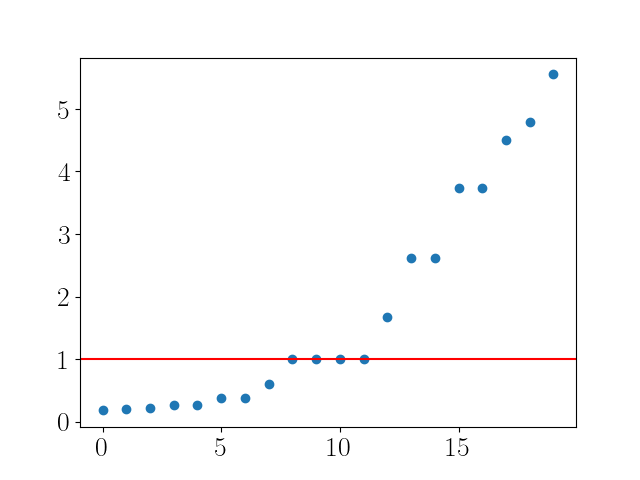

In [69]:
params = JosephsonParameters(W = 5 , 
                             L = 10,
                             t = 1,
                             flux = 0,
                             energy = 0.5,
                             Delta = 0,
                             phase = 0,
                             mu = 0.5,
                             tol = 1e-4)
F_pos , F_neg , debug_dict = calculate_transfer_matrices(0 , params)
evals = debug_dict['evals']
plt.figure()
plt.scatter(np.arange(len(evals)),np.sort(np.abs(evals)))
plt.axhline(y = 1 , color = 'r')

In [67]:
list_of_eigenvalues = debug_dict['list_of_eigenvalues']
pos_p_evals = list_of_eigenvalues[0]
neg_p_evals = list_of_eigenvalues[1]
print(np.angle(pos_p_evals))
print(np.angle(neg_p_evals))

[0.4865001 0.4865001]
[-0.4865001 -0.4865001]


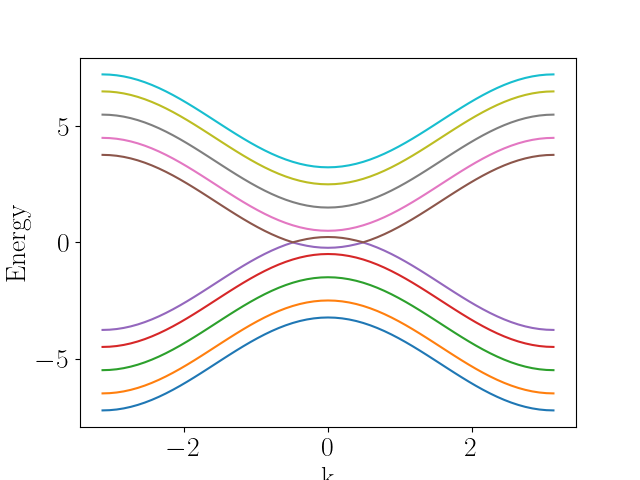

In [71]:
# Cross-checking with kwant:
sym = kwant.TranslationalSymmetry((-1 , 0))
lat = kwant.lattice.square(norbs = 2)
syst = kwant.Builder(sym)
for i in range(params.W):
    syst[lat(0 , i)] = 4*params.t*sz - params.mu*sz + params.Delta*sx
    if i > 0:
        syst[lat(0 , i), lat(0 , i-1)] = -params.t*sz
    syst[lat(1 , i) , lat(0 , i)] = -params.t*sz

syst = syst.finalized()
kwant.plotter.bands(syst);
plt.axhline(y = params.energy , color = 'r')
